# Evaluate

* Before you get started, please make sure your `vocab.json` and `config.max_answers` corresponds to your model's parameters to be evaluated.

In [4]:
eval_config = {
    "model_path": "logs/ms_30epochs.ckpt"
}

## Define our evaluation function:

In [1]:
import sys
import os.path
import mindspore
from mindspore import Tensor, nn, Model, context
from mindspore import load_checkpoint, load_param_into_net
from mindspore import ops as P
from mindspore.ops import functional as F
from mindspore.ops import composite as C
from mindspore.common.parameter import ParameterTuple
from mindspore.train.callback import LossMonitor, CheckpointConfig, ModelCheckpoint, TimeMonitor
from mindspore.nn.loss.loss import _Loss
import numpy as np
from tqdm import tqdm
import config
import data
import model
import utils
import mindspore.context as context
import json

def evaluate(net, loader, tracker, prefix='', epoch=0):
    """ Run an epoch over the given loader """
    arg_max = P.Argmax(axis=1, output_type=mindspore.int32)
    cat = P.Concat(axis=0) # Warning: `Concat` a list of tensors is not supported in mindspore 1.1.x
    
    net.set_train(False)
    tracker_class, tracker_params = tracker.MeanMonitor, {}
    answ = []
    idxs = []
    accs = []

    tq = tqdm(loader, desc='{} E{:03d}'.format(prefix, epoch), ncols=0)
    loss_tracker = tracker.track('{}_loss'.format(prefix), tracker_class(**tracker_params))
    acc_tracker = tracker.track('{}_acc'.format(prefix), tracker_class(**tracker_params))
    for v, q, a, idx, q_len in tq:
        output, loss, acc = net(v, q, a, idx, q_len)
        answer = arg_max(output)
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1))
        
        # Update loss and accuracy in console line
        loss_tracker.append(loss.asnumpy())
        for a in acc.asnumpy():
            acc_tracker.append(a)
        fmt = '{:.4f}'.format
        tq.set_postfix(loss=fmt(loss_tracker.mean.value), acc=fmt(acc_tracker.mean.value))
    
    # Cast to python types for JSON serialization
    answ = list(map(int, list(cat(answ).asnumpy())))
    accs = list(cat(accs).asnumpy().astype(float))
    idxs = list(map(int, list(cat(idxs).asnumpy())))
    return answ, accs, idxs


## Load your model:

In [18]:
from train import OutLossAccuracyWrapper
val_loader = data.get_loader(val=True)

net = model.Net(val_loader.source.num_tokens)
param_dict = load_checkpoint(eval_config["model_path"])
if param_dict is not None: print("Successfully loaded pretrained model from {}.".format(eval_config["model_path"]))
load_param_into_net(net, param_dict)

tracker = utils.Tracker()
eval_net = OutLossAccuracyWrapper(net) # for evaluation

tracker = utils.Tracker()

[WARNING] ME(30595:139704215619392,MainProcess):2021-07-15-15:28:54.352.749 [mindspore/train/serialization.py:466] Remove parameter prefix name: net., continue to load.


Successfully loaded pretrained model from logs/ms_30epochs.ckpt.


## Evaluate the model now:

In [19]:
answ, accs, idxs = evaluate(eval_net, val_loader, tracker, prefix='val', epoch=0)

val E000: 168it [01:20,  2.09it/s, acc=0.0019, loss=3.6721]


## Generate a result JSON file for later visualization.

In [21]:
import numpy as np
import json

dump_path = 'data/results/val_val2014_real_results.json'

print("Average accuracy:", np.mean(accs))

with open('data/questions/val.json', 'r') as fd:
   questions_json = json.load(fd)

with open('vocab.json', 'r') as fd:
   vocab = json.load(fd)
   answ_dict = vocab['answer']

question_ids = [question['question_id'] for question in questions_json['questions']]
results = []

for i in range(len(idxs)):
   results.append({"answer": list(answ_dict.keys())[list(answ_dict.values()).index(answ[i])], "question_id": question_ids[idxs[i]]})

with open(dump_path, 'w') as fd:
   json.dump(results, fd)

Average accuracy: 0.0019174248209526856


## Visualize it!

loading VQA annotations and questions into memory...
0:00:00.287782
creating index...
index created!
Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 0.19

Per Question Type Accuracy is the following:
how many : 0.98
what is the : 0.31
is this a : 0.13
what is the man : 0.00
does the : 0.00
how : 0.25
is this : 0.00
what kind of : 0.05
is the : 0.00
none of the above : 0.15
are : 0.00
is it : 0.00
are the : 0.05
what : 0.06
is : 0.00
why is the : 0.00
where are the : 0.49
are these : 0.00
was : 0.00
what is : 0.60
what color : 0.00
why : 0.46
what is in the : 0.53
what color is the : 0.02
what are : 0.00
what is this : 0.00
what are the : 0.39
what is the person : 0.00
what color are the : 0.00
who is : 0.00
what color is : 0.00
which : 0.00
is the person : 0.00
does this : 0.00
has : 0.00
where is the : 0.00
what type of : 0.56
are they : 0

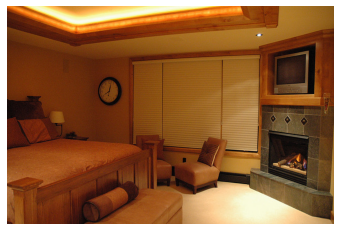

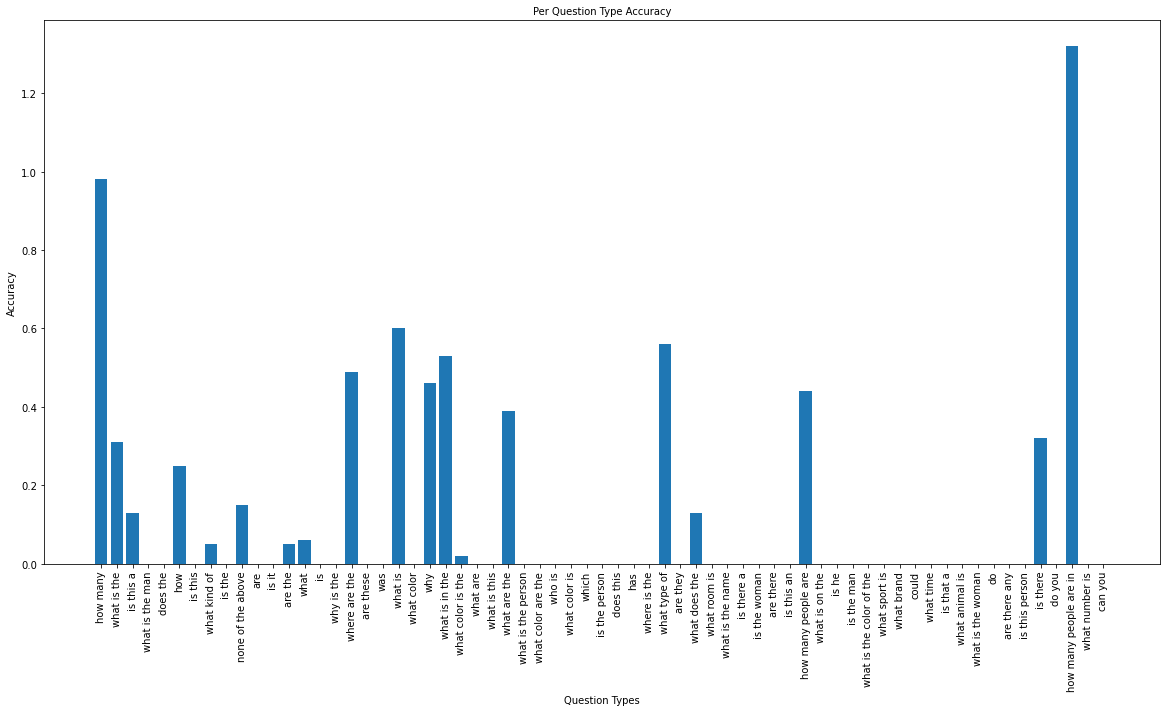

In [22]:
"""
input: results file (generated by your model), annotations file, questions file
output: evalAnsType, evalQuesType, evalQA, accuracy
"""
import sys
dataDir = '.'
sys.path.insert(0, '%s/PythonHelperTools/vqaTools' %(dataDir))
sys.path.insert(0, '%s/PythonEvaluationTools/vqaEvaluation' %(dataDir))
from vqa import VQA
from vqaEval import VQAEval
import matplotlib.pyplot as plt
import skimage.io as io
import json
import random
import os

# set up file names and paths
dataDir		='./data'
train_test_val = 'val'
dataSubType = 'train2014' if train_test_val == 'train' else 'val2014'
annFile     = '%s/annotations/%s.json'%(dataDir, train_test_val)
quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
# annFile     = '%s/results/val_fake_annotations.json'%(dataDir) # a tiny annotation file in 'results' for demo
# quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
imgDir 		= '%s/images/%s/' %(dataDir, train_test_val)
resultType  = 'real'
fileTypes   = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType'] 

# An example result json file has been provided in './Results' folder.  

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] = ['%s/results/%s_%s_%s_%s.json'%(dataDir, train_test_val, dataSubType,  \
resultType, fileType) for fileType in fileTypes]

resFile = dump_path

# create vqa object and vqaRes object
vqa = VQA(annFile, quesFile)
vqaRes = vqa.loadRes(resFile, quesFile)

# create vqaEval object by taking vqa and vqaRes
vqaEval = VQAEval(vqa, vqaRes, n=2)   #n is precision of accuracy (number of places after decimal), default is 2

# evaluate results
"""
If you have a list of question ids on which you would like to evaluate your results, pass it as a list to below function
By default it uses all the question ids in annotation file
"""
vqaEval.evaluate() 

# print accuracies
print("\n")
print("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
print("Per Question Type Accuracy is the following:")
for quesType in vqaEval.accuracy['perQuestionType']:
	print("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
print("\n")
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print("\n")
# demo how to use evalQA to retrieve low score result
evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy
if len(evals) > 0:
	print('ground truth answers')
	randomEval = random.choice(evals)
	randomAnn = vqa.loadQA(randomEval)
	vqa.showQA(randomAnn)

	print('\n')
	print('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
	ann = vqaRes.loadQA(randomEval)[0]
	print("Answer:   %s\n" %(ann['answer']))

	imgId = randomAnn[0]['image_id']
	imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
	if os.path.isfile(imgDir + imgFilename):
		I = io.imread(imgDir + imgFilename)
		plt.imshow(I)
		plt.axis('off')
		plt.show()

# plot accuracy for various question types
plt.figure(figsize=(20,10))
# plt.figure(dpi=80)
plt.bar(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].values(), align='center')
plt.xticks(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].keys(), rotation='90', fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=10)
plt.xlabel('Question Types', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.show()

# save evaluation results to ./Results folder
json.dump(vqaEval.accuracy,     open(accuracyFile,     'w'))
json.dump(vqaEval.evalQA,       open(evalQAFile,       'w'))
json.dump(vqaEval.evalQuesType, open(evalQuesTypeFile, 'w'))
json.dump(vqaEval.evalAnsType,  open(evalAnsTypeFile,  'w'))
